In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from PIL import ImageFile, Image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, \
    Input, Conv2DTranspose, Flatten, Dense, Activation, Add, Lambda, GlobalAveragePooling2D
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


from createTrain import createTrains

In [2]:
no_path = './wm-nowm/train/no-watermark/'
water_path = './wm-nowm/train/watermark/'
val_path_water = './wm-nowm/valid/watermark/'
val_path_nowater = './wm-nowm/valid/no-watermark/'

H = 128
W = 128
C = 256
batch_size = 1
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
xTrain, yTrain = createTrains(no_path, water_path, W, H)
xVal, yVal = createTrains(val_path_nowater, val_path_water, W, H)

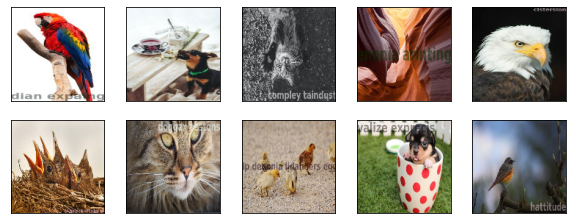

In [11]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(xTrain[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_ssim as ssim

K = 2
alph = 0.3
bat = 0.3
depth = 10
batch_size = 32
EPOCHS = 50
SIGMA = 25
epsilon = 1e-10




def batchnorm(x, train_phase, scope_bn):
    #Batch Normalization
    #Ioffe S, Szegedy C. Batch normalization: accelerating deep network training by reducing internal covariate shift[J]. 2015:448-456.
    with tf.variable_scope(scope_bn, reuse=tf.AUTO_REUSE):
        beta = tf.get_variable(name='beta', shape=[x.shape[-1]], initializer=tf.constant_initializer([0.]), trainable=True)
        gamma = tf.get_variable(name='gamma', shape=[x.shape[-1]], initializer=tf.constant_initializer([1.]), trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(train_phase, mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

def InstanceNorm(inputs, name):
    with tf.variable_scope(name):
        mean, var = tf.nn.moments(inputs, axes=[1, 2], keep_dims=True)
        scale = tf.get_variable("scale", shape=mean.shape[-1], initializer=tf.constant_initializer([1.]))
        shift = tf.get_variable("shift", shape=mean.shape[-1], initializer=tf.constant_initializer([0.]))
        return (inputs - mean) * scale / tf.sqrt(var + 1e-10) + shift

def conv(name, inputs, nums_out, ksize, strides, padding="SAME", is_SN=False):
    with tf.variable_scope(name):
        W = tf.get_variable("W", shape=[ksize, ksize, int(inputs.shape[-1]), nums_out], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b", shape=[nums_out], initializer=tf.constant_initializer(0.))
        if is_SN:
            return tf.nn.conv2d(inputs, spectral_norm(name, W), [1, strides, strides, 1], padding) + b
        else:
            return tf.nn.conv2d(inputs, W, [1, strides, strides, 1], padding) + b

def deconv(name, inputs, nums_out, ksize, strides, padding="SAME"):
    with tf.variable_scope(name):
        w = tf.get_variable("W", shape=[ksize, ksize, nums_out, int(inputs.shape[-1])], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b", [nums_out], initializer=tf.constant_initializer(0.))
        # inputs = tf.image.resize_nearest_neighbor(inputs, [H*strides, W*strides])
        # return tf.nn.conv2d(inputs, w, [1, 1, 1, 1], padding) + b
    return tf.nn.conv2d_transpose(inputs, w, [tf.shape(inputs)[0], int(inputs.shape[1])*strides, int(inputs.shape[2])*strides, nums_out], [1, strides, strides, 1], padding=padding) + b


def fully_connected(name, inputs, nums_out):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        W = tf.get_variable("W", [int(inputs.shape[-1]), nums_out], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b", [nums_out], initializer=tf.constant_initializer(0.))
        return tf.matmul(inputs, W) + b


def spectral_norm(name, w, iteration=1):
    #Spectral normalization which was published on ICLR2018,please refer to "https://www.researchgate.net/publication/318572189_Spectral_Normalization_for_Generative_Adversarial_Networks"
    #This function spectral_norm is forked from "https://github.com/taki0112/Spectral_Normalization-Tensorflow"
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    with tf.variable_scope(name, reuse=False):
        u = tf.get_variable("u", [1, w_shape[-1]], initializer=tf.truncated_normal_initializer(), trainable=False)
    u_hat = u
    v_hat = None

    def l2_norm(v, eps=1e-12):
        return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)

    for i in range(iteration):
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = l2_norm(v_)
        u_ = tf.matmul(v_hat, w)
        u_hat = l2_norm(u_)
    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
    w_norm = w / sigma
    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = tf.reshape(w_norm, w_shape)
    return w_norm

def leaky_relu(x, slope=0.2):
    return tf.maximum(x, slope*x)

def sobel(inputs):
    filter_h = tf.reshape(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32), [3, 3, 1, 1])
    filter_V = tf.reshape(tf.constant([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=tf.float32), [3, 3, 1, 1])
    h = tf.nn.conv2d(inputs, filter_h, [1, 1, 1, 1], "SAME")
    V = tf.nn.conv2d(inputs, filter_V, [1, 1, 1, 1], "SAME")
    return h, V

def Format(name, inputs, train_phase):
    with tf.variable_scope(name):
        temp = inputs
        for l in range(depth-1):
            inputs = conv("conv"+str(l), inputs, 64, 3, 1)
            inputs = batchnorm(inputs, train_phase, "bn"+str(l))
            inputs = tf.nn.relu(inputs)
        res = conv("conv"+str(depth), inputs, C, 3, 1)
        return temp + res, res

def vgg16(inputs):
    weight = np.load("./vgg16//vgg16.npy", encoding="latin1").item()
    inputs = tf.nn.relu(tf.nn.conv2d(inputs, weight["conv1_1"][0], [1, 1, 1, 1], "SAME") + tf.constant(weight["conv1_1"][1]))
    inputs = tf.nn.relu(tf.nn.conv2d(inputs, weight["conv1_2"][0], [1, 1, 1, 1], "SAME") + tf.constant(weight["conv1_2"][1]))
    inputs = tf.nn.max_pool(inputs, [1, 3, 3, 1], [1, 2, 2, 1], "SAME")
    inputs = tf.nn.relu(tf.nn.conv2d(inputs, weight["conv2_1"][0], [1, 1, 1, 1], "SAME") +  tf.constant(weight["conv2_1"][1]))
    inputs = tf.nn.relu(tf.nn.conv2d(inputs, weight["conv2_2"][0], [1, 1, 1, 1], "SAME") +  tf.constant(weight["conv2_2"][1]))
    return inputs


class FormResNet:
    def __init__(self, name):
        self.name = name

    def __call__(self, inputs, train_phase):
        res = {}
        for k in range(K):
            with tf.variable_scope("Format"+str(k)):
                inputs, res0 = Format(str(k), inputs, train_phase)
                res[str(k)] = res0
        return inputs, res

# vgg16(tf.placeholder(tf.float32, [None, 40, 40, 3]))

class Main:
    def __init__(self):
        self.clean_img = tf.placeholder(tf.float32, [batch_size, H, W, C])
        self.noised_img = tf.placeholder(tf.float32, [batch_size, H, W, C])
        self.train_phase = tf.placeholder(tf.bool)
        form_resnet = FormResNet("FormResNet")
        self.denoised_img, self.res = form_resnet(self.noised_img, self.train_phase)
        self.L_pix = tf.reduce_mean(tf.reduce_sum(tf.square(self.denoised_img - self.clean_img), [1, 2, 3]))
        self.Phi = vgg16(tf.concat([self.denoised_img, self.denoised_img, self.denoised_img], 3))
        self.Phi_ = vgg16(tf.concat([self.clean_img, self.clean_img, self.clean_img], 3))
        self.L_feat = tf.reduce_mean(tf.square(self.Phi - self.Phi_))
        self.L_grad = tf.reduce_mean(tf.reduce_sum(tf.abs(sobel(self.denoised_img)[0] - sobel(self.clean_img)[0]) +\
                      tf.abs(sobel(self.denoised_img)[1] - sobel(self.clean_img)[1]), [1, 2, 3]))
        self.L_cross = (1 - alph - bat ) * self.L_pix + alph * self.L_feat + bat * self.L_grad
        self.Opt = tf.train.AdamOptimizer(1e-4).minimize(self.L_cross)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def train(self):
        filepath = "./quzao/data/cleandenoise//"
        filenames = os.listdir(filepath)
        saver = tf.train.Saver()
        for epoch in range(EPOCHS):
            for i in range(filenames.__len__()//batch_size):
                cleaned_batch = np.zeros([batch_size, H, W, C], dtype=np.float32)
                for idx, filename in enumerate(filenames[i*batch_size:i*batch_size+batch_size]):
                    image = cv2.cvtColor(xTrain[i].astype('float32'), cv2.COLOR_BGR2RGB)
                    cleaned_batch[idx, :, :, 0] = np.array(Image.open(filepath+filename))
                noised_batch = cleaned_batch + np.random.normal(0, SIGMA, cleaned_batch.shape)
                self.sess.run(self.Opt, feed_dict={self.clean_img: cleaned_batch, self.noised_img: noised_batch, self.train_phase: True})
                if i % 10 == 0:
                    [loss, denoised_img] = self.sess.run([self.L_cross, self.denoised_img], feed_dict={self.clean_img: cleaned_batch, self.noised_img: noised_batch, self.train_phase: False})
                    PSNR = psnr(np.uint8(cleaned_batch[0, :, :, 0]), np.uint8(denoised_img[0, :, :, 0]))
                    SSIM = ssim(np.uint8(cleaned_batch[0, :, :, 0]), np.uint8(denoised_img[0, :, :, 0]))
                    print("Epoch: %d, Step: %d, Loss: %g, psnr: %g, ssim: %g"%(epoch, i, loss, PSNR, SSIM))
                    compared = np.concatenate((cleaned_batch[0, :, :, 0], noised_batch[0, :, :, 0], denoised_img[0, :, :, 0]), 1)
                    Image.fromarray(np.uint8(compared)).save("./compar/formresult//"+str(epoch)+"_"+str(i)+".jpg")
                if i % 500 == 0:
                    saver.save(self.sess, "./compar/formpara//FormResNet.ckpt")
            np.random.shuffle(filenames)

    def test(self, cleaned_path="./TestingSet//02.png"):
        cleaned_img = np.reshape(np.array(Image.open(cleaned_path), dtype=np.float32), [1, 256, 256, 1])
        noised_img = cleaned_img + np.random.normal(0, SIGMA, cleaned_img.shape)
        [denoised_img] = self.sess.run([self.denoised_img], feed_dict={self.clean_img: cleaned_img, self.noised_img: noised_img, self.train_phase: False})
        PSNR = psnr(np.uint8(cleaned_img[0, :, :, 0]), np.uint8(denoised_img[0, :, :, 0]))
        SSIM = ssim(np.uint8(cleaned_img[0, :, :, 0]), np.uint8(denoised_img[0, :, :, 0]))
        print("psnr: %g, ssim: %g" % (PSNR, SSIM))
        compared = np.concatenate((cleaned_img[0, :, :, 0], noised_img[0, :, :, 0], denoised_img[0, :, :, 0]), 1)
        Image.fromarray(np.uint8(compared)).show()

if __name__ == "__main__":
    m = Main()
    m.train()